In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 47.7 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [6]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [7]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [8]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))

weights /= np.sum(weights, axis=1)[:,np.newaxis]

In [9]:
portf_rtns = np.dot(weights,avg_returns)

portf_vol = []
for i in range(0, len(weights)): 
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
  

portf_vol = np.array(portf_vol) 
portf_sharpe_ratio = portf_rtns / portf_vol 

In [10]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

In [11]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

In [12]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

In [13]:
max_sharpe_portf_w = weights[np.argmax(portf_results_df.sharpe_ratio)]

In [14]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

In [15]:
min_vol_portf_w = weights[np.argmin(portf_results_df.volatility)]

In [16]:
import scipy
import scipy.linalg

In [17]:
T = 1
N = len(returns_df)
N_SIM = 10**3

In [18]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [19]:
shares = max_sharpe_portf_w
print(shares)

[0.00190711 0.00285349 0.9952394 ]


In [20]:
mu = np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)
print(mu)
print(sigma)

0.2127967732208313
0.08008330414898554


In [21]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

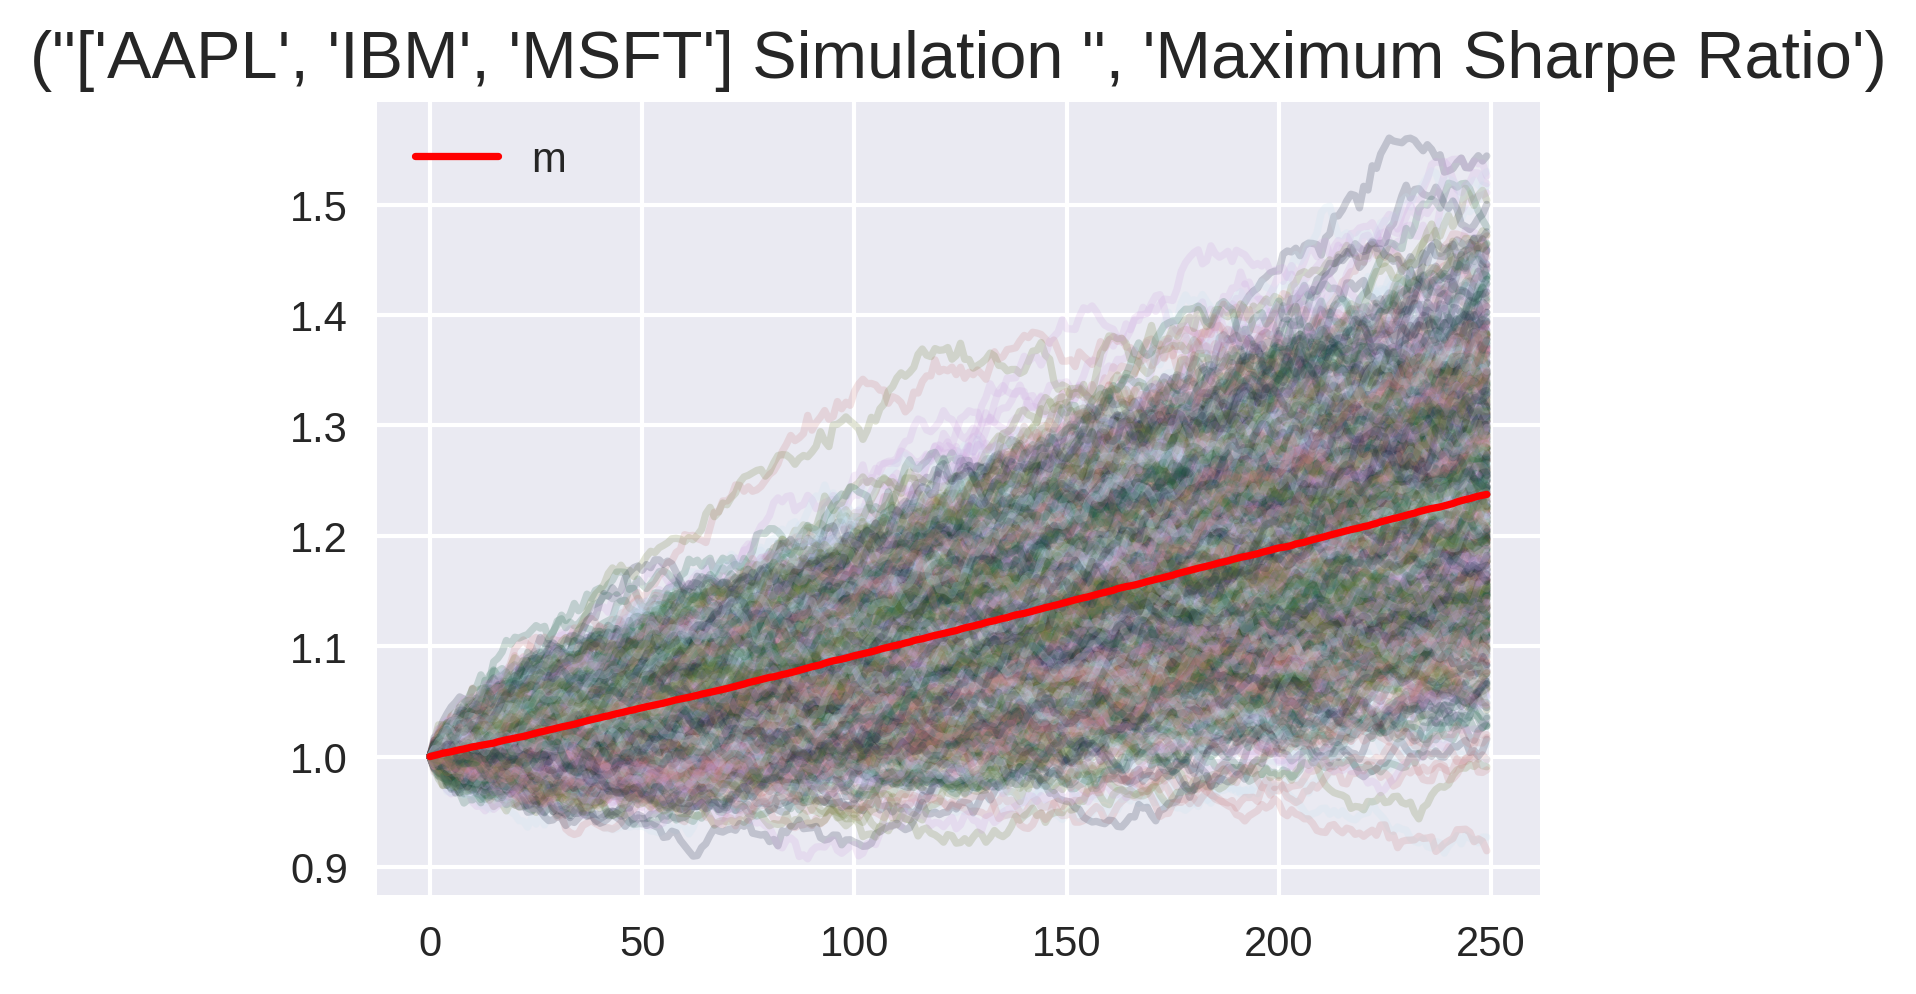

In [22]:
# prepare objects for plotting

plot_title = (f'{RISKY_ASSETS} Simulation ', 'Maximum Sharpe Ratio')


gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1 = ax.plot(gbm_simulations_df.mean(axis=1), 
                  color='red')

ax.set_title(plot_title, fontsize=16)
ax.legend((line_1), ('m'))


plt.show()

In [23]:
shares = min_vol_portf_w

In [24]:
mu = np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)
print(mu)
print(sigma)

-0.12384060683077751
0.05098750862774557


In [25]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

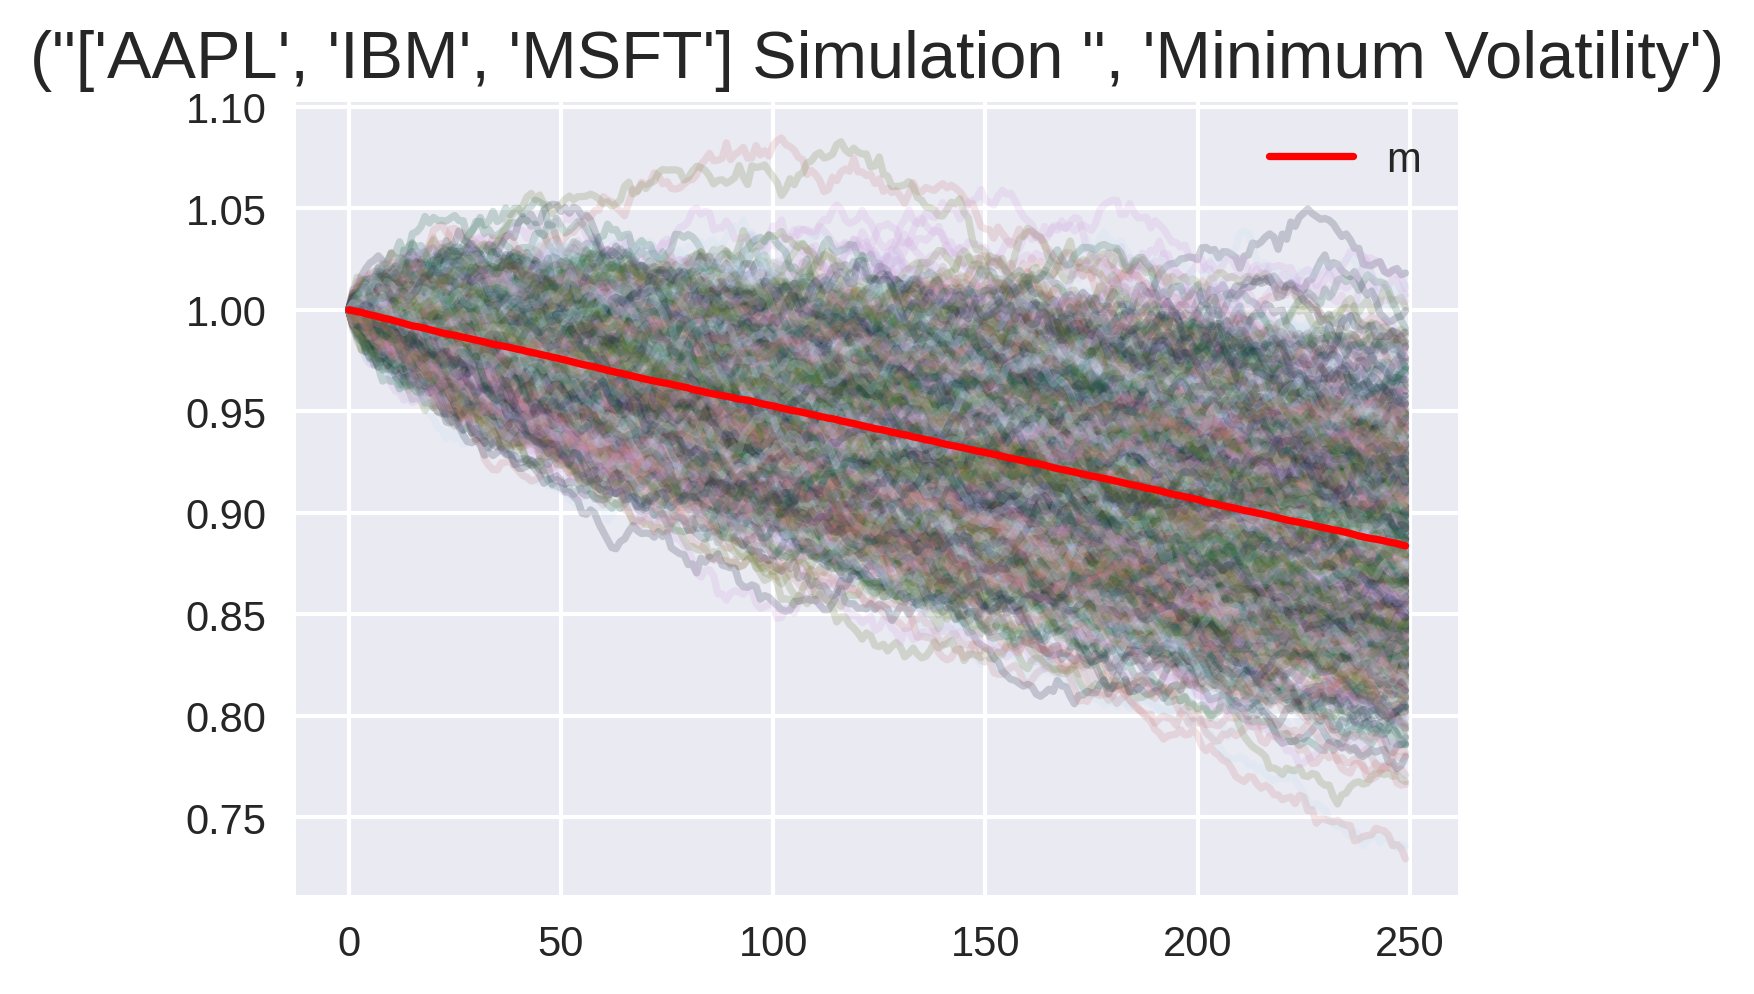

In [26]:
# prepare objects for plotting

plot_title = (f'{RISKY_ASSETS} Simulation ', 'Minimum Volatility')


gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1 = ax.plot(gbm_simulations_df.mean(axis=1), 
                  color='red')

ax.set_title(plot_title, fontsize=16)
ax.legend((line_1), ('m'))


plt.show()